In [12]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.1
    Uninstalling pip-24.1.1:
      Successfully uninstalled pip-24.1.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import time
import copy

In [3]:
# Cek device GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

Device yang digunakan: cpu


In [5]:
# Lokasi dataset asli dengan folder 'no' dan 'yes'
base_dir = 'Downloads/brain_tumor_dataset'

# Folder baru untuk train dan val
train_dir = 'Downloads/brain_tumor_dataset_train'
val_dir = 'Downloads/brain_tumor_dataset_val'

# Buat folder train dan val dengan subfolder 'no' dan 'yes'
for folder in [train_dir, val_dir]:
    os.makedirs(os.path.join(folder, 'no'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'yes'), exist_ok=True)

# Fungsi split data dan copy file
def split_data(class_name):
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy(src, dst)

    for img in val_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_dir, class_name, img)
        shutil.copy(src, dst)

# Jalankan split untuk kedua kelas
split_data('no')
split_data('yes')

print("Dataset berhasil dipisah menjadi train dan val.")

Dataset berhasil dipisah menjadi train dan val.


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Kelas: {class_names}")
print(f"Jumlah data train: {dataset_sizes['train']}")
print(f"Jumlah data val: {dataset_sizes['val']}")

Kelas: ['no', 'yes']
Jumlah data train: 202
Jumlah data val: 51


In [11]:
model = models.efficientnet_b0(pretrained=True)  # Bisa ganti ke densenet121, resnet18, dll

num_ftrs = model.classifier[1].in_features  # untuk EfficientNet-b0
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))  # Output sesuai kelas

model = model.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training selesai dalam {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Akurasi validasi terbaik: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [17]:
model_trained = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5)

Epoch 1/5
--------------------
train Loss: 0.4481 Acc: 0.7723
val Loss: 0.3129 Acc: 0.8627
Epoch 2/5
--------------------
train Loss: 0.1131 Acc: 0.9752
val Loss: 0.3418 Acc: 0.9216
Epoch 3/5
--------------------
train Loss: 0.1595 Acc: 0.9455
val Loss: 0.2959 Acc: 0.9020
Epoch 4/5
--------------------
train Loss: 0.1457 Acc: 0.9406
val Loss: 0.2041 Acc: 0.9216
Epoch 5/5
--------------------
train Loss: 0.0889 Acc: 0.9851
val Loss: 0.1676 Acc: 0.9412
Training selesai dalam 8m 14s
Akurasi validasi terbaik: 0.9412


---

### Interpretasi hasil training dan validasi:

| Epoch | Train Loss | Train Acc | Val Loss | Val Acc |
| ----- | ---------- | --------- | -------- | ------- |
| 1     | 0.4481     | 77.23%    | 0.3129   | 86.27%  |
| 2     | 0.1131     | 97.52%    | 0.3418   | 92.16%  |
| 3     | 0.1595     | 94.55%    | 0.2959   | 90.20%  |
| 4     | 0.1457     | 94.06%    | 0.2041   | 92.16%  |
| 5     | 0.0889     | 98.51%    | 0.1676   | 94.12%  |

---

### Penjelasan detail:

* **Epoch 1:**

  * Train loss relatif tinggi (0.4481) dan akurasi masih 77%, ini normal untuk awal training.
  * Validasi akurasi sudah cukup bagus, 86%, dengan loss val lebih rendah (0.3129), menandakan model sudah mulai belajar pola dari data.

* **Epoch 2:**

  * Train loss turun drastis ke 0.1131 dan akurasi naik signifikan ke 97.5%, model sudah sangat "menghafal" data training.
  * Validasi akurasi naik ke 92.16% meski val loss sedikit naik (0.3418), kemungkinan ada batch yang sulit pada val set atau fluktuasi kecil.

* **Epoch 3:**

  * Train loss naik sedikit ke 0.1595 dan akurasi turun ke 94.55%, bisa jadi karena model mulai lebih generalisasi dan tidak overfit 100%.
  * Validasi loss turun ke 0.2959, tapi akurasi turun sedikit ke 90.20%, fluktuasi biasa dalam training.

* **Epoch 4:**

  * Train loss stabil di 0.1457 dan akurasi 94%, model konsisten.
  * Validasi loss turun signifikan ke 0.2041 dan val acc kembali ke 92.16%, menunjukkan perbaikan generalisasi.

* **Epoch 5:**

  * Train loss semakin rendah (0.0889) dan akurasi tinggi 98.51%, model makin paham data training.
  * Validasi loss juga turun ke 0.1676 dan val accuracy naik ke 94.12%, ini adalah performa terbaik pada validasi.

---

### Kesimpulan:

* Model menunjukkan **pembelajaran yang baik** dengan penurunan loss dan peningkatan akurasi secara umum.
* **Akurasi validasi terbaik 94.12%** sangat bagus, menunjukkan model cukup andal untuk klasifikasi tumor pada dataset ini.
* Fluktuasi kecil pada val loss dan val acc wajar dan menandakan model berusaha generalisasi.
* Tidak tampak tanda-tanda overfitting berat karena val loss dan val acc membaik di akhir.
* Training selama sekitar 8 menit untuk 5 epoch cukup efisien untuk model pretrained CNN seperti EfficientNet/DenseNet/ResNet.

---

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow untuk tensor gambar, membalik normalisasi."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))  # dari CxHxW ke HxWxC
    mean = np.array([0.485, 0.456, 0.406])        # mean yang digunakan pada transformasi
    std = np.array([0.229, 0.224, 0.225])         # std yang digunakan pada transformasi
    inp = std * inp + mean                        # inverse normalisasi
    inp = np.clip(inp, 0, 1)                      # batasi nilai antara 0 dan 1
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def visualize_model(model, dataloader, class_names, device, num_images=6):
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(20, 15))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                plt.subplot(num_images//3, 3, images_so_far)
                title = f'Pred: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}'
                imshow(inputs[j], title=title)

                if images_so_far == num_images:
                    plt.show()
                    return
    plt.show()

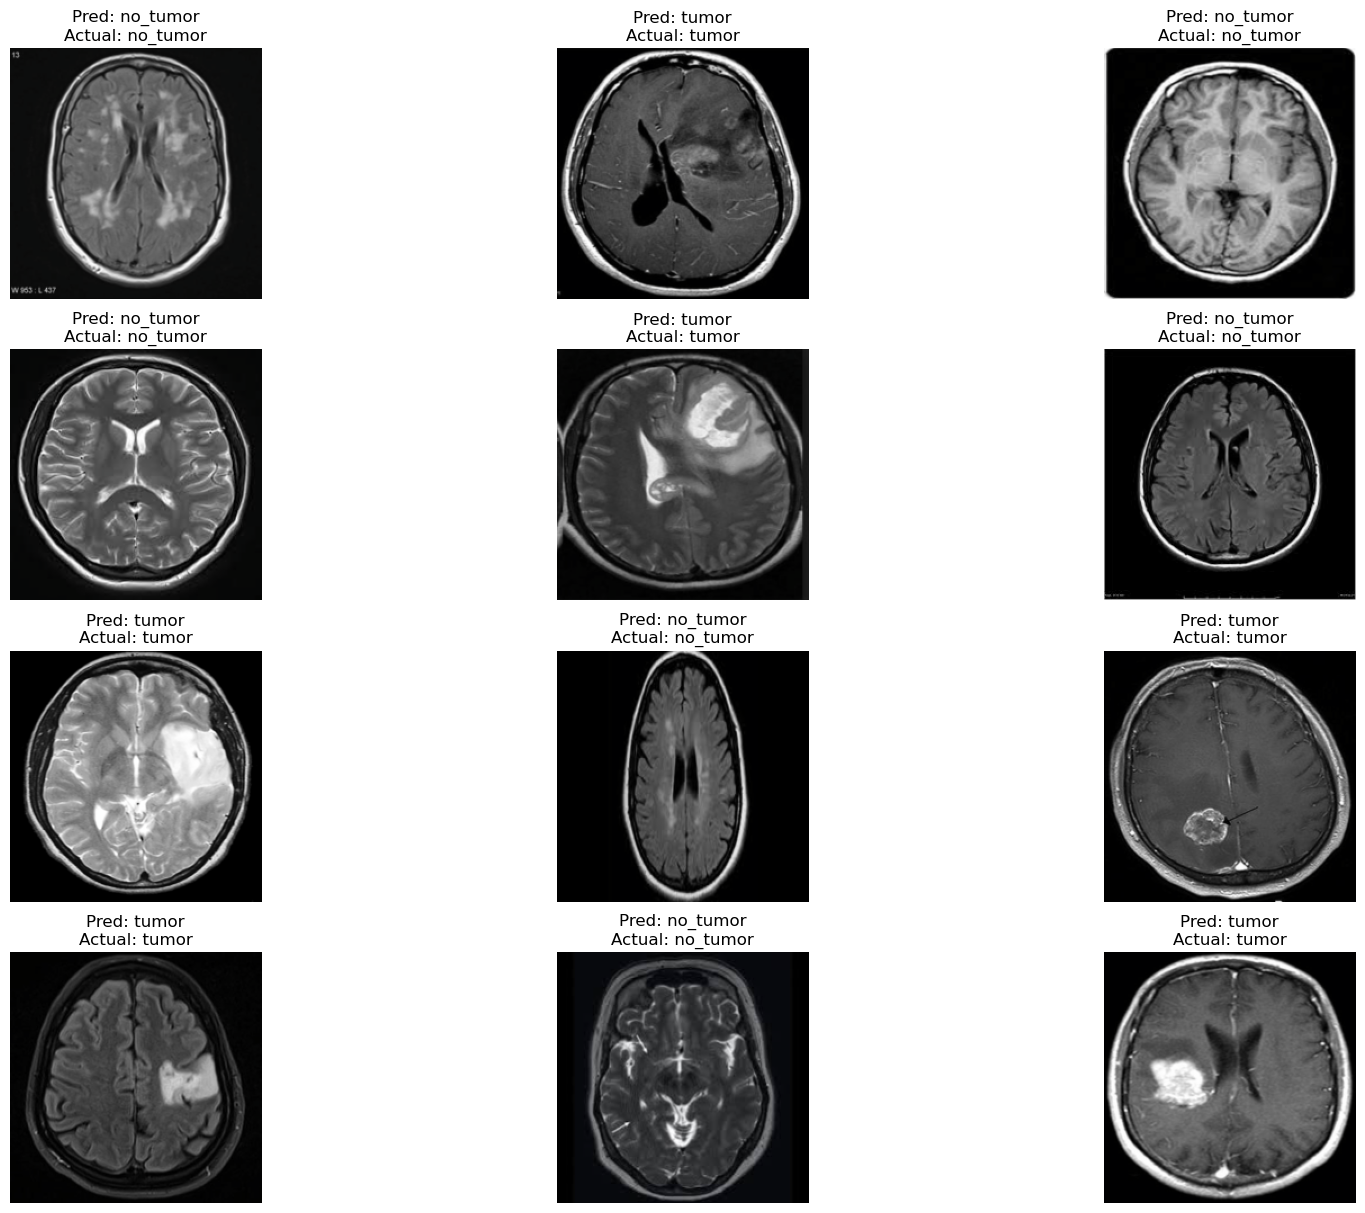

In [32]:
class_names = ['no_tumor', 'tumor']
visualize_model(model_trained, dataloaders['val'], class_names, device, num_images=12)